In [3]:
import os
localfs_path = os.environ.get('SCRATCH_LOCAL') + '/'

In [4]:
os.environ['_JAVA_OPTIONS'] = f'-Djava.io.tmpdir={localfs_path}'

import hail as hl

hl.init(
    tmp_dir=(localfs_path+'tmp_hail_3'),
    spark_conf={'spark.driver.memory': '10G', 'spark.executor.memory': '10G'},
    default_reference='GRCh38'
) 

Picked up _JAVA_OPTIONS: -Djava.io.tmpdir=/localfs/4736297/
Picked up _JAVA_OPTIONS: -Djava.io.tmpdir=/localfs/4736297/


23/09/10 11:20:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.2
SparkUI available at http://ac0520:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.113-cf32652c5077
LOGGING: writing to /net/pr2/projects/plgrid/plggneuromol/imdik-zekanowski-gts/preprocessing/oligogenic-model/hail-20230910-1120-0.2.113-cf32652c5077.log


In [3]:
import sys
!{sys.executable} -m pip install seaborn


[notice] A new release of pip is available: 23.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [5]:
from hail.plot import show
from pprint import pprint
from bokeh.layouts import gridplot
import numpy as np
hl.plot.output_notebook()
import bokeh
from scipy import stats

from bokeh.plotting import figure, output_notebook, show
output_notebook

Loading BokehJS ...

<function bokeh.io.output.output_notebook(resources=None, verbose=False, hide_banner=False, load_timeout=5000, notebook_type='jupyter')>

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
from oligogenic_model import (
    read_in_pheno_anno_pw,
    aggregate_per_burden,
    stand_burden,
    stand_with_ref,
    read_in_pheno_anno_sport,
    model_assignment,
    read_in_pheno_anno_all
)

### Use average burden from polish controls for normalisation (this is the difference between this and the other mode)

In [8]:
mt = read_in_pheno_anno_sport(
    '/net/pr2/projects/plgrid/plggneuromol/imdik-zekanowski-gts/data/mts/oligogenic-model/gts_and_s.mt',
    'gts_sport_for_hist_')

2023-09-09 21:03:51.855 Hail: INFO: Reading table without type imputation
  Loading field 'f0' as type str (not specified)
  Loading field 'f1' as type str (not specified)
  Loading field 'f2' as type str (not specified)
  Loading field 'f3' as type str (not specified)
  Loading field 'f4' as type str (not specified)
  Loading field 'f5' as type str (not specified)
  Loading field 'f6' as type str (not specified)
  Loading field 'f7' as type str (not specified)
  Loading field 'f8' as type str (not specified)
2023-09-09 21:03:52.854 Hail: INFO: Reading table without type imputation
  Loading field 'Gene stable ID' as type str (not specified)
  Loading field 'UniProtKB Gene Name symbol' as type str (not specified)
2023-09-09 21:03:53.979 Hail: INFO: Reading table to impute column types
2023-09-09 21:03:55.022 Hail: INFO: Finished type imputation
  Loading field 'ID' as type str (imputed)
  Loading field 'family' as type str (imputed)
  Loading field 'sex' as type str (imputed)
  Loading

In [ ]:
reference = aggregate_per_burden(mt, 'gts_sport_for_hist_2')

In [ ]:
reference = stand_burden(reference, 'gts_sport_for_hist_3')

In [ ]:
reference = hl.read_matrix_table(localfs_path+'gts_sport_for_hist_3stand_per_gene.mt')

In [ ]:
mt_all = read_in_pheno_anno_all(
    '/net/pr2/projects/plgrid/plggneuromol/imdik-zekanowski-gts/data/mts/oligogenic-model/gts_and_s.mt',
    'gts_sport_for_hist_all'
)

In [ ]:
mt_all = aggregate_per_burden(mt_all, 'gts_sport_all')

In [ ]:
mt_all.describe()

In [ ]:
mt_all = hl.read_matrix_table(localfs_path+'gts_sport_allper_burden_agg.mt')

In [ ]:
mt_all = stand_with_ref(
    mt_all,
    reference,
    'stand_with_gts_sport_4'
)

In [9]:
mt = hl.read_matrix_table(localfs_path+'stand_with_gts_sport_4stand_per_gene_with_ref.mt')

In [10]:
cadds = [0,5,10]

In [11]:
mt.count()

(17844, 287)

### Draw a per-group histogram of oligogenic scores

In [12]:
genes = ['CHADL', 'DRD2', 'MAOA', 'PCDH10', 'HTR2A', 'SLITRK5', 'SORCS3', 'KCNQ5', 'CDH9', 'CHD8']

In [13]:
mt = mt.filter_rows(
        hl.literal(genes).contains(mt.nearest_genes_20kb)
    )

In [14]:
mt = mt.distinct_by_col()

In [15]:
cadds = [0,5,10]

In [16]:
assignments = mt.annotate_cols(
        **{
            f'n_non_ref_above_cadd_sum_{c}': hl.agg.sum(mt[f'per_gene_stdev_above_cadd_{c}'])
            for c in cadds
        },
        **{
            f'n_non_ref_weited_above_cadd_sum_{c}': hl.agg.sum(mt[f'per_gene_stdev_weited_above_cadd_{c}'])
            for c in cadds
        }
    )

In [17]:
assignments = assignments.annotate_cols(
    test_group = hl.if_else(
        assignments.group == 'local_controls',
        'controls',
        hl.if_else(
            assignments.phenotypes.disease == 'NO',
            'healthy family members',
            hl.if_else(
                ((assignments.phenotypes.phenotype == 'GTS') & (assignments.phenotypes.family == '.')),
                'severe GTS',
                 hl.if_else(
                     assignments.phenotypes.phenotype == 'GTS',
                     'GTS',
                     'non-GTS TDs'
                 )
            )
        )
    )
)

In [18]:
assignments.aggregate_cols(hl.agg.counter(assignments.test_group))

{'GTS': 47,
 'controls': 102,
 'healthy family members': 55,
 'non-GTS TDs': 42,
 'severe GTS': 40}

In [19]:
assignments = assignments.filter_cols(assignments.n_non_ref_above_cadd_sum_0 > -30)
# this excludes the low quality samples

In [20]:
def make_score_hist(assignments):
    
    sns.set(rc={'figure.figsize':(14,10)})
    all_ass = np.array(assignments.n_non_ref_above_cadd_sum_0.collect())
    
    groups = ['GTS_familial',
              'GTS_sporadic',
              'healthy_family_members',
              'sport',
              'tics']
    
    all_samples = np.array(assignments.test_group.collect())
    
    
    for group in groups:
   
        subset = all_ass[np.where(all_samples == group)]
        palette = {
            'sport':sns.diverging_palette(220, 20)[0],
            'healthy_family_members':sns.diverging_palette(220, 20)[1],
            'tics':sns.diverging_palette(220, 20)[2],
            'GTS_familial':sns.diverging_palette(220, 20)[3],
            'GTS_sporadic':sns.diverging_palette(220, 20)[4]
        }
        
       
        # Draw the density plot
        sns.histplot(subset, kde = True,
                     label = group,
                     stat="percent",
                     kde_kws=dict(cut=3),
                     alpha=.4,
                     binrange=[-10,10],
                     binwidth=1,
                     color=palette[group]
                    )
        

    
    # Plot formatting
    plt.legend(prop={'size': 16}, title = 'Airline')
    plt.title('Density Plot with Multiple Airlines')
    plt.xlabel('Delay (min)')
    plt.ylabel('Density')
    plt.savefig("hists.png")
    
    
    return(plt)

In [21]:
def make_score_box(assignments):
      
    sns.set(rc={'figure.figsize':(10,8)})
    sns.set(font_scale=1.5)
    sns.set_style("ticks")
    
    #plt.xticks(rotation=45)
    all_ass = np.array(assignments.n_non_ref_above_cadd_sum_0.collect())
    
    groups = ['GTS',
              'controls',
              'healthy family members',
              'non-GTS TDs',
              'severe GTS']
    
    palette = {
            'controls':sns.diverging_palette(220, 20)[0],
            'healthy family members':sns.diverging_palette(220, 20)[1],
            'non-GTS TDs':sns.diverging_palette(220, 20)[2],
            'GTS':sns.diverging_palette(220, 20)[3],
            'severe GTS':sns.diverging_palette(220, 20)[4]
        }
    
    all_samples = np.array(assignments.test_group.collect())
    
    sns.boxplot(
        x=all_samples,
        y=all_ass,
        hue=all_samples,
        dodge=False,
        palette=palette,     
        order=[
               'controls',
               'healthy family members',
               'non-GTS TDs',
               'GTS',
               'severe GTS']
    )
    
    
    # Plot formatting
    plt.title('oligogenic score per group')
    plt.xlabel('group')
    plt.ylabel('score value')
    plt.legend([],[], frameon=False)
    
    plt.xticks(rotation=45)
    
    sns.despine()
    plt.savefig("box.png")

    
    return(plt)

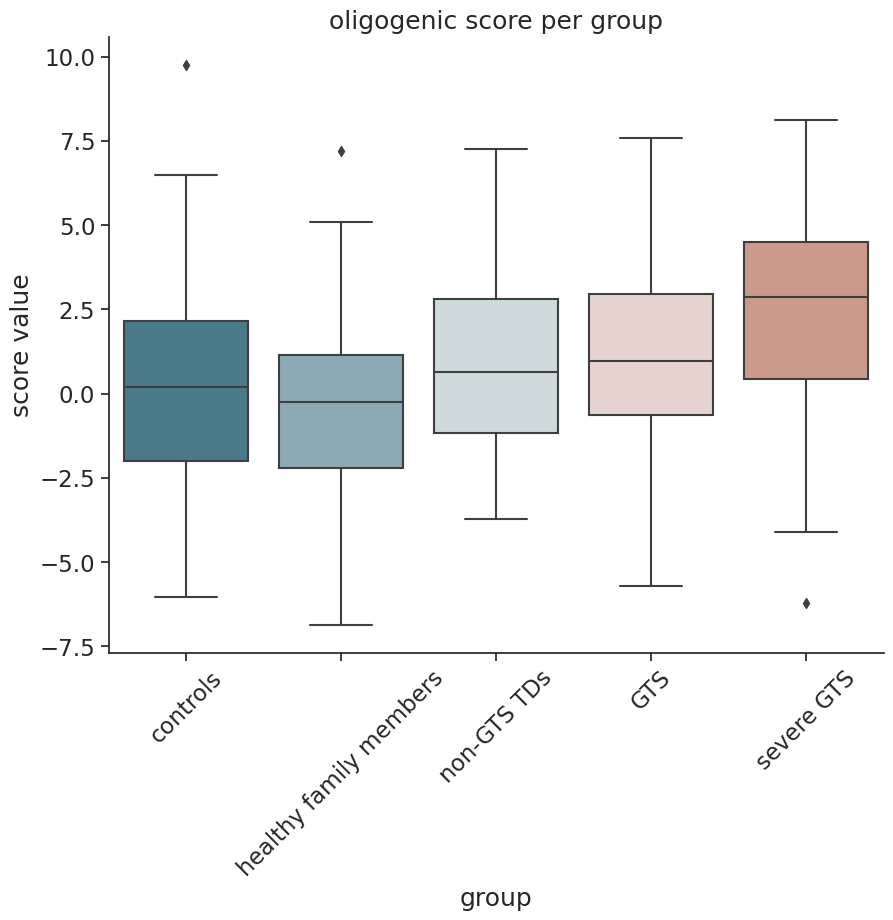

In [22]:
p = make_score_box(assignments)

In [23]:
from scipy.stats import f_oneway

In [24]:
all_ass = np.array(assignments.n_non_ref_above_cadd_sum_0.collect())
all_samples = np.array(assignments.test_group.collect())
    
subsets = []

groups = ['GTS',
          'controls',
          'healthy family members',
          'non-GTS TDs',
          'severe GTS']

for group in groups:
    subsets.append(all_ass[np.where(all_samples == group)]) 

In [27]:
for idx,sub in enumerate(subsets):
    print(groups[idx])
    print(stats.shapiro(sub))

GTS
ShapiroResult(statistic=0.9903865456581116, pvalue=0.9658746719360352)
controls
ShapiroResult(statistic=0.9854888916015625, pvalue=0.3306565284729004)
healthy family members
ShapiroResult(statistic=0.9900866150856018, pvalue=0.9298732280731201)
non-GTS TDs
ShapiroResult(statistic=0.963097095489502, pvalue=0.22590790688991547)
severe GTS
ShapiroResult(statistic=0.9756730794906616, pvalue=0.5490260720252991)


In [25]:
f_oneway(*subsets)

F_onewayResult(statistic=6.245021085651749, pvalue=7.989712982062609e-05)

In [28]:
print(groups[0], 'vs', groups[1], stats.ttest_ind(subsets[0], subsets[1]))

print(groups[0], 'vs', groups[2], stats.ttest_ind(subsets[0], subsets[2]))

print(groups[4], 'vs', groups[2], stats.ttest_ind(subsets[4], subsets[2]))

print(groups[0], 'vs', groups[4], stats.ttest_ind(subsets[0], subsets[4]))

print(groups[2], 'vs', groups[3], stats.ttest_ind(subsets[2], subsets[3]))

print(groups[0], 'vs', groups[3], stats.ttest_ind(subsets[0], subsets[3]))

print(groups[3], 'vs', groups[4], stats.ttest_ind(subsets[3], subsets[4]))

print(groups[3], 'vs', groups[1], stats.ttest_ind(subsets[3], subsets[1]))

print(groups[1], 'vs', groups[2], stats.ttest_ind(subsets[1], subsets[2]))

print(groups[4], 'vs', groups[1], stats.ttest_ind(subsets[4], subsets[1]))

GTS vs controls Ttest_indResult(statistic=1.836844196427626, pvalue=0.06826641828427835)
GTS vs healthy family members Ttest_indResult(statistic=2.692405934688229, pvalue=0.008331011236255395)
severe GTS vs healthy family members Ttest_indResult(statistic=4.6118484811578515, pvalue=1.2853824903624763e-05)
GTS vs severe GTS Ttest_indResult(statistic=-1.9233445634362347, pvalue=0.05786545202625514)
healthy family members vs non-GTS TDs Ttest_indResult(statistic=-2.2978707977788124, pvalue=0.023835718644081842)
GTS vs non-GTS TDs Ttest_indResult(statistic=0.23396954249272944, pvalue=0.8155847660403754)
non-GTS TDs vs severe GTS Ttest_indResult(statistic=-2.041672236641259, pvalue=0.04465463398753503)
non-GTS TDs vs controls Ttest_indResult(statistic=1.4533295698209463, pvalue=0.14838623240066182)
controls vs healthy family members Ttest_indResult(statistic=1.10278336579664, pvalue=0.2718305360673089)
severe GTS vs controls Ttest_indResult(statistic=3.9287313051593817, pvalue=0.00013401548

In [30]:
assignments.aggregate_cols(hl.agg.counter(assignments.phenotypes.sex))

{'F': 69, 'M': 110, None: 102}

In [31]:
sport_f = ['B434', 'B437', 'B440', 'B447', 'B514', 'B519', 'B521']

In [33]:
# check boxplot for sex:

assignments = assignments.annotate_cols(
    sex = hl.if_else(
        assignments.group == 'local_controls',
        hl.if_else(
            hl.literal(sport_f).contains(assignments.s),
            'F',
            'M'
        ),
        assignments.phenotypes.sex
    )
)

In [34]:
def make_score_box(assignments):
      
    sns.set(rc={'figure.figsize':(10,8)})
    sns.set(font_scale=1.5)
    sns.set_style("ticks")
    
    #plt.xticks(rotation=45)
    all_ass = np.array(assignments.n_non_ref_above_cadd_sum_0.collect())
    
    groups = ['F',
              'M']
    
    palette = {
            'F':sns.diverging_palette(220, 20)[0],
            'M':sns.diverging_palette(220, 20)[4]
        }
    
    all_samples = np.array(assignments.sex.collect())
    
    sns.boxplot(
        x=all_samples,
        y=all_ass,
        hue=all_samples,
        dodge=False,
        palette=palette,     
        order=[
        'F',
        'M'
        ]
    )
    
    
    # Plot formatting
    plt.title('oligogenic score per sex')
    plt.xlabel('group')
    plt.ylabel('score value')
    plt.legend([],[], frameon=False)
    
    plt.xticks(rotation=45)
    
    sns.despine()
    plt.savefig("box.png")

    
    return(plt)

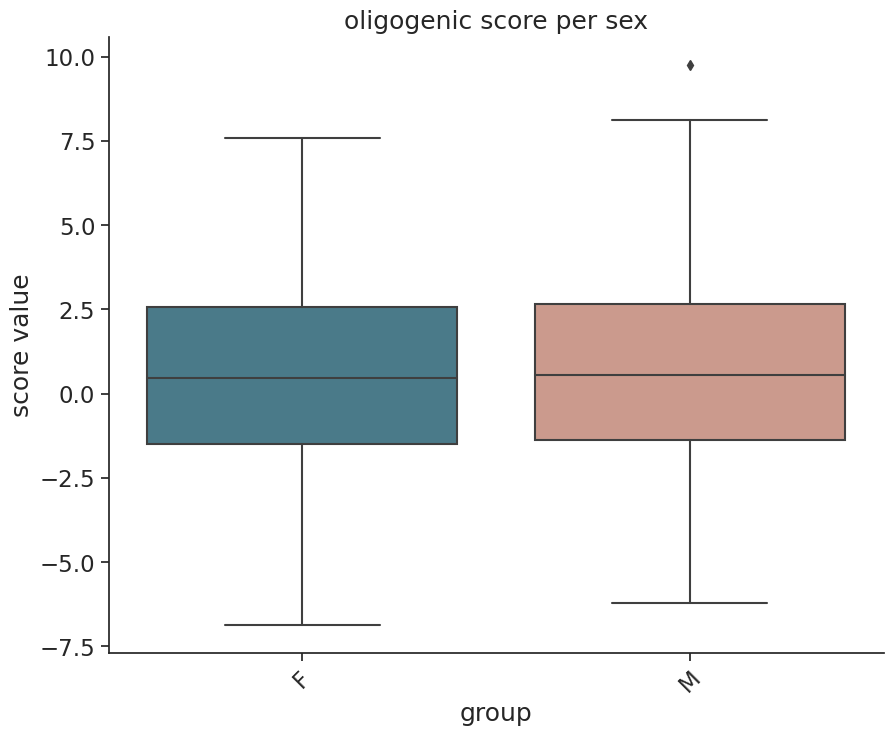

In [35]:
p = make_score_box(assignments)

In [41]:
all_ass = np.array(assignments.n_non_ref_above_cadd_sum_0.collect())
all_samples = np.array(assignments.sex.collect())
    
subsets = []

groups = ['M',
         'F']

for group in groups:
    subsets.append(all_ass[np.where(all_samples == group)]) 

print(groups[0], 'vs', groups[1], stats.ttest_ind(subsets[0], subsets[1]))

In [42]:
assignments.aggregate_cols(hl.agg.counter(assignments.phenotypes.add_pheno))

{'.': 122,
 'ADHD': 3,
 'ADHDANX': 2,
 'ADHDMDDANX': 4,
 'ADHDOCD': 1,
 'ADHDOCDANX': 3,
 'ADHDOCDMDD': 1,
 'ADHDOCDMDDANX': 4,
 'ANX': 8,
 'ASD': 8,
 'ASDADHD': 1,
 'ASDADHDANX': 1,
 'ASDMDDANX': 1,
 'MDD': 2,
 'OCD': 6,
 'OCDMDD': 4,
 'OCDMDDANX': 7,
 'SCHIMDDANX': 1,
 None: 102}

In [75]:
# boxplot per commorbidity:


coms = ['ASD', 'MDD', 'ADHD', 'OCD', 'ANX']

assignments = assignments.annotate_cols(
    **{
        com: hl.if_else(assignments.phenotypes.add_pheno.contains(com), com, f'no {com}')
            for com in coms
        }
)

In [78]:
def make_box_com(assignments, com):
      
    sns.set(rc={'figure.figsize':(10,8)})
    sns.set(font_scale=1.5)
    sns.set_style("ticks")
    
    all_ass = np.array(assignments.n_non_ref_above_cadd_sum_0.collect())
    
    palette = {
        com:sns.diverging_palette(220, 20)[0],
        f'no {com}':sns.diverging_palette(220, 20)[4]
        }
    
    all_samples = np.array(assignments[com].collect())
    
    sns.boxplot(
        x=all_samples,
        y=all_ass,
        hue=all_samples,
        dodge=False,
        palette=palette
    )
    
    
    # Plot formatting
    plt.title(f'oligogenic score per comorbidity:{com}')
    plt.xlabel('group')
    plt.ylabel('score value')
    plt.legend([],[], frameon=False)
    
    plt.xticks(rotation=45)
    
    sns.despine()
    plt.savefig(f'box{com}.png')
    plt.clf()
    return(plt)
    

In [80]:
coms = ['ASD', 'MDD', 'ADHD', 'OCD', 'ANX']

for com in coms:
    make_box_com(assignments, com)
    
    all_ass = np.array(assignments.n_non_ref_above_cadd_sum_0.collect())
    all_samples = np.array(assignments[com].collect())

    subsets = []

    groups = [com,
             f'no {com}']

    for group in groups:
        subsets.append(all_ass[np.where(all_samples == group)]) 

    print(groups[0], 'vs', groups[1], stats.ttest_ind(subsets[0], subsets[1]))

ASD vs no ASD Ttest_indResult(statistic=-0.330538842474438, pvalue=0.7413837792636597)
MDD vs no MDD Ttest_indResult(statistic=1.6814943198074273, pvalue=0.09443051214773403)
ADHD vs no ADHD Ttest_indResult(statistic=1.2054033664007704, pvalue=0.2296566403360712)
OCD vs no OCD Ttest_indResult(statistic=0.6886955762735656, pvalue=0.4919165688512669)
ANX vs no ANX Ttest_indResult(statistic=2.196971730011964, pvalue=0.02932139234162486)


<Figure size 1000x800 with 0 Axes>